# Materials Project Formation Energy Distribution

MP has a curious bimodality in its formation energies. Considering the formation energies are the result of a carefully fitted correction scheme (see `pymatgen.entries.compatibility.MaterialsProject2020Compatibility`) that depends mainly on the composition of a compound, let's look at which elements dominate the upper and lower modes.


In [ ]:
!pip install pymatviz

In [ ]:
import warnings

import pandas as pd
import plotly.express as px
import plotly.io as pio
from mp_api.client import MPRester

from pymatviz import count_elements, ptable_heatmap_plotly
from pymatviz.enums import Key


__author__ = "Janosh Riebesell"
__date__ = "2022-08-11"

pio.renderers.default = "png"

Check if all of MP has a bi-modal formation energy distribution. Short answer: yes it does.


In [ ]:
# Set environment variable "MP_API_KEY"
e_form_col = "formation_energy_per_atom"
fields = [Key.mat_id, Key.formula_pretty, e_form_col, "energy_type"]

warnings.filterwarnings("ignore", "No Pauling electronegativity for", UserWarning)

e_form_all_mp = MPRester(use_document_model=False).materials.thermo.search(
    fields=fields,
    thermo_types=None,
    # thermo_types=["GGA_GGA+U_R2SCAN"],
    chunk_size=200,
)

Retrieving ThermoDoc documents:   0%|          | 0/341314 [00:00<?, ?it/s]

In [ ]:
df_e_form = pd.DataFrame(e_form_all_mp).set_index(Key.mat_id)
df_e_form = df_e_form.rename(columns={"formula_pretty": Key.formula})
df_e_form.head(10)

,formula,formation_energy_per_atom,energy_type
material_id,,,
mp-632401,B,0.291536,GGA
mp-1180008,O2,0.418581,GGA
mp-1180064,O2,0.385741,GGA
mp-1094120,Nb,0.189748,GGA
mp-1244987,Zn,0.058375,GGA
mp-1245093,Zn,0.055069,GGA
mp-1245184,Zn,0.048852,GGA
mp-1245266,Zn,0.052316,GGA
mp-640416,Rb,0.056728,GGA


In [ ]:
# cache MP data
%store df_e_form

# load cached MP data
# %store -r df_e_form

Stored 'df_e_form' (DataFrame)


In [ ]:
df_e_form.energy_type.value_counts()

energy_type
GGA       186878
GGA+U      82970
R2SCAN     69409
Name: count, dtype: int64

In [ ]:
df_e_form_gga_only = df_e_form.query("energy_type in ('GGA', 'GGA+U')")
expected = 121_555
if len(df_e_form_gga_only) != expected:
    print(f"{expected=} GGA & GGA+U entries, got {len(df_e_form_gga_only)}")

expected=121555 GGA & GGA+U entries, got 269848


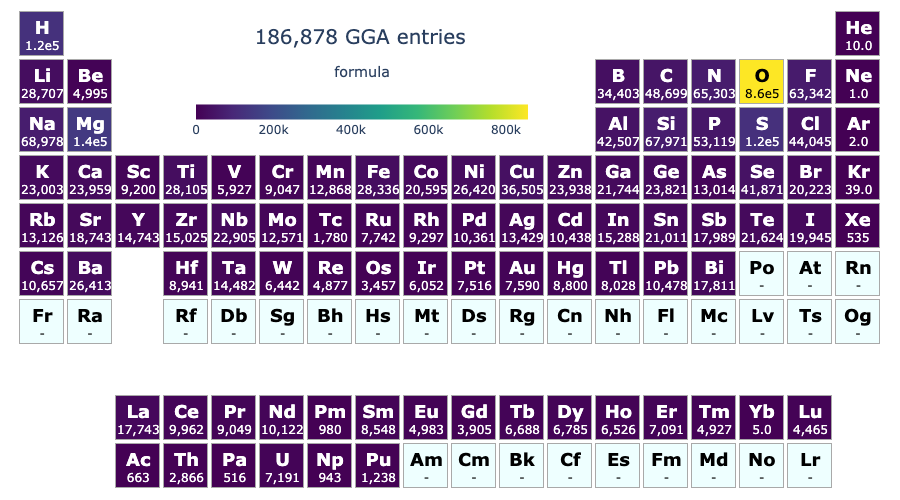

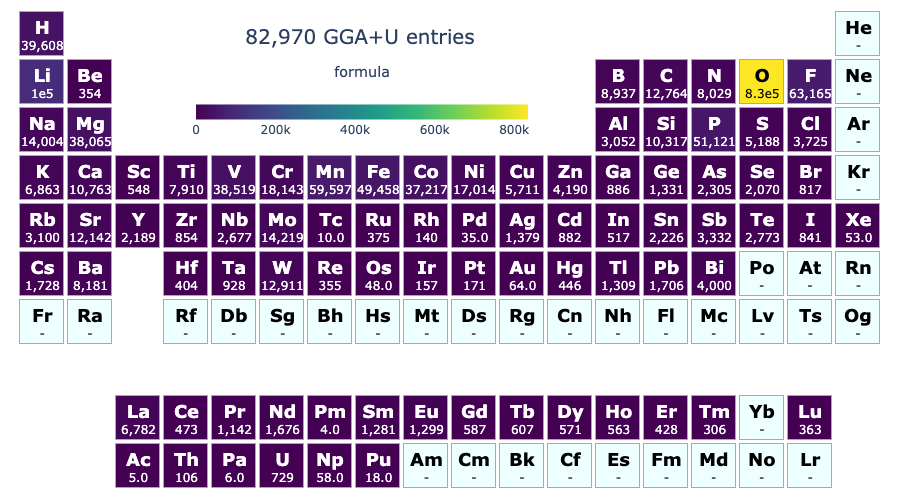

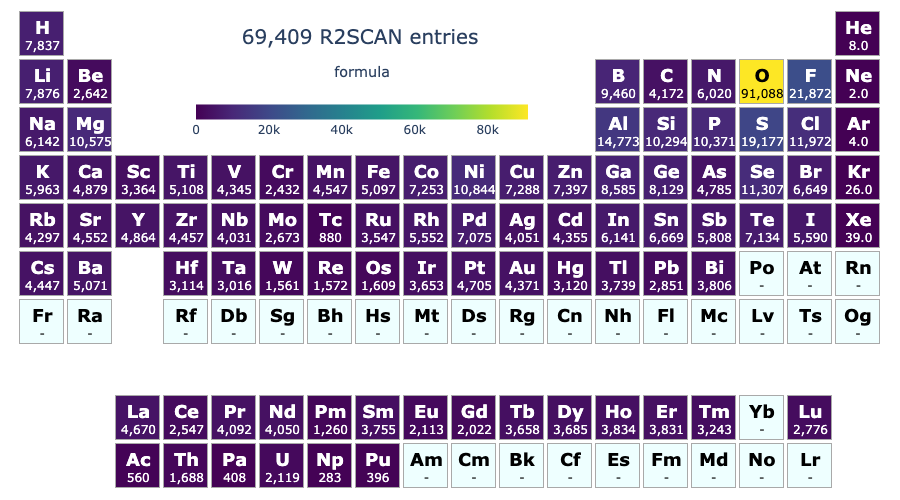

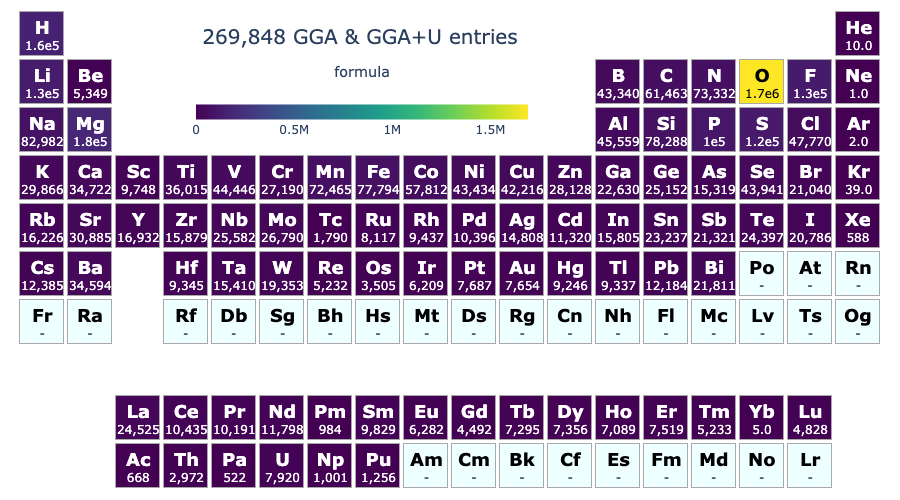

In [ ]:
for energy_type, df_e_type in [
    *df_e_form.groupby("energy_type"),
    ("GGA & GGA+U", df_e_form_gga_only),
]:
    fig = ptable_heatmap_plotly(df_e_type[Key.formula])
    title = f"{len(df_e_type):,} {energy_type} entries"
    fig.layout.title = dict(text=title, x=0.4, y=0.94, font=dict(size=20))
    fig.show()

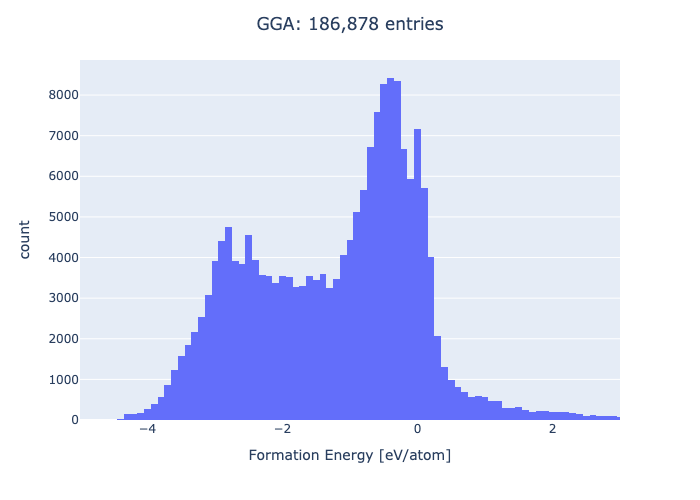

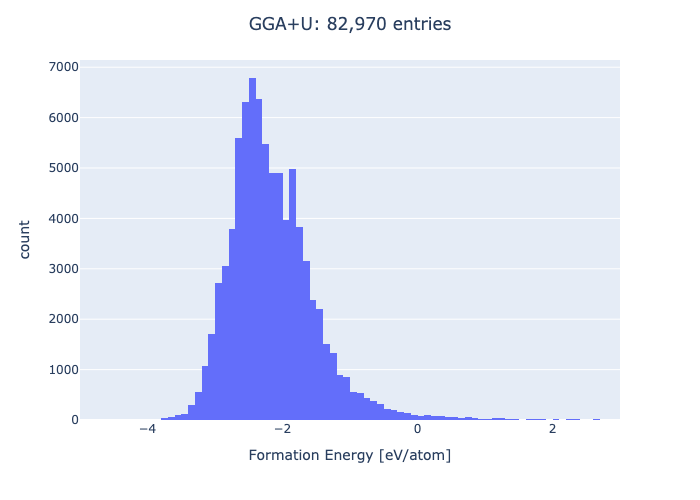

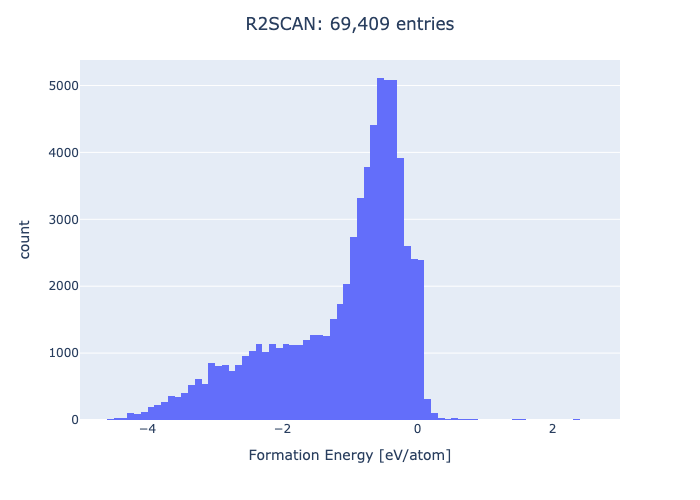

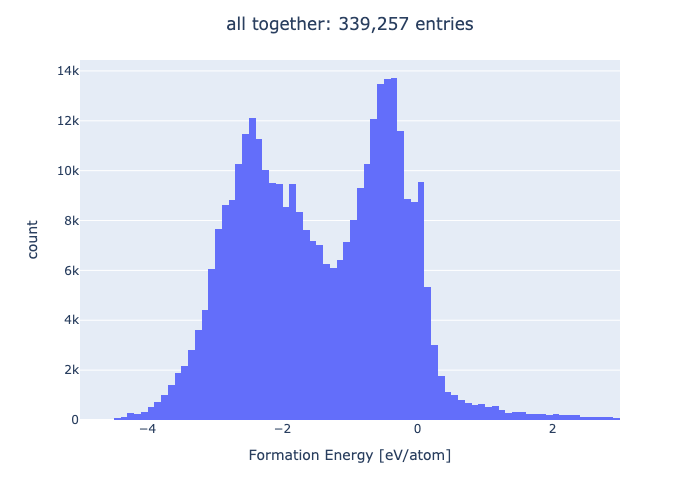

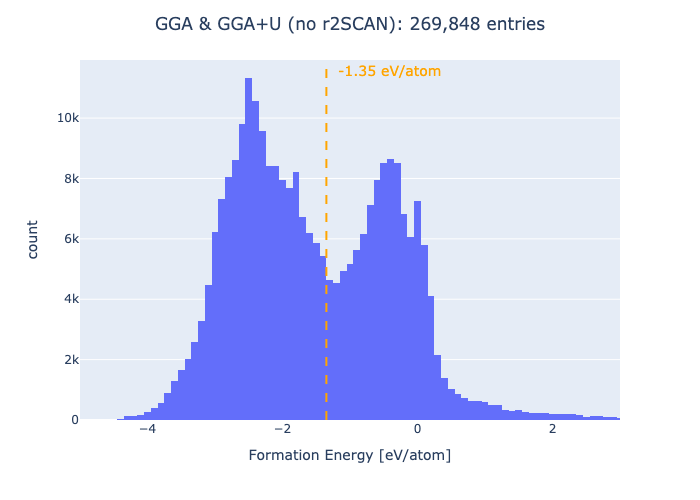

In [ ]:
labels = {
    "formation_energy_per_atom": "Formation Energy [eV/atom]",
    "count": "Number of Entries",
}
for energy_type, df_e_type in [
    *df_e_form.groupby("energy_type"),
    ["all together", df_e_form],
    ["GGA & GGA+U (no r2SCAN)", df_e_form_gga_only],
]:
    fig = px.histogram(
        df_e_type.query(f"-5 < {e_form_col} < 5"),
        x=e_form_col,
        nbins=150,
        range_x=(-5, 3),
        labels=labels,
    )
    title = f"{energy_type}: {len(df_e_type):,} entries"
    fig.layout.title = dict(text=title, x=0.5)

    # add vertical line at valley of GGA & GGA+U bimodal distribution
    if energy_type == "GGA & GGA+U (no r2SCAN)":
        e_form_valley = -1.35
        anno = dict(
            text=f"{e_form_valley} eV/atom",
            font=dict(size=14, color="orange"),
            xshift=10,
        )
        fig.add_vline(
            e_form_valley, line=dict(color="orange", dash="dash"), annotation=anno
        )

    fig.show()

Plot element heatmap for GGA and GGA+U entries above and below `e_form_valley`.


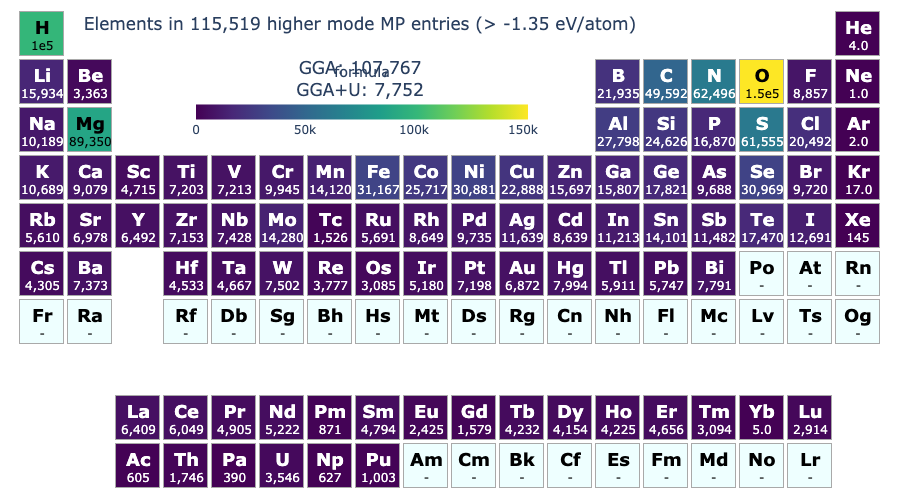

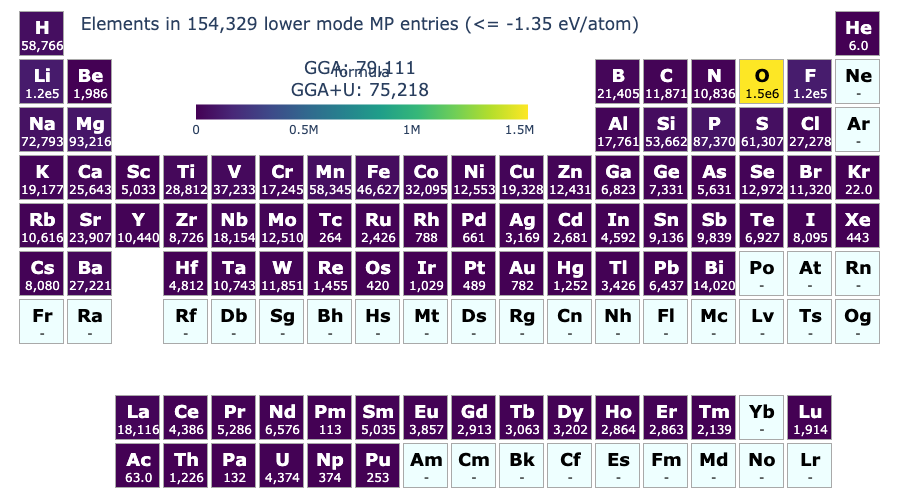

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):
    df_query = df_e_form_gga_only.query(f"{e_form_col} {comparator} {e_form_valley}")
    fig = ptable_heatmap_plotly(df_query[Key.formula])
    title = (
        f"Elements in {len(df_query):,} {label} mode MP entries "
        f"({comparator} {e_form_valley} eV/atom)<br><br>"
    )
    title += "<br>".join(
        f"{e_type}: {cnt:,}"
        for e_type, cnt in df_query.energy_type.value_counts().items()
    )

    fig.layout.title = dict(text=title, x=0.4, y=0.94)
    fig.show()

Looks like the lower mode is mostly oxides, whereas the higher mode is more diverse also containing many nitrides, sulfides and selenides.

Another way to visualize this are bar charts.


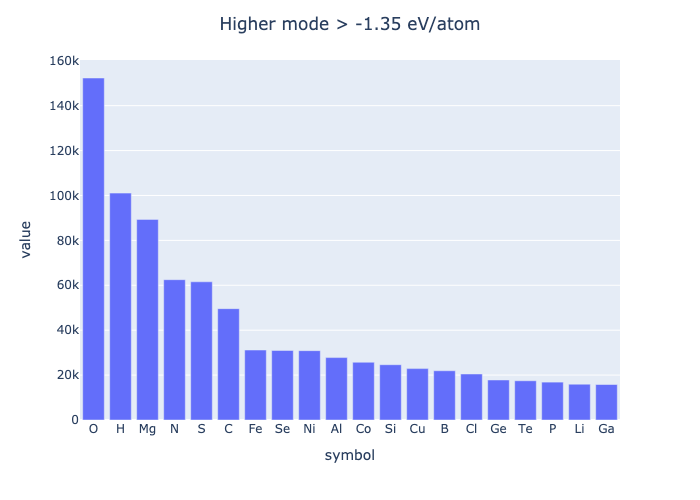

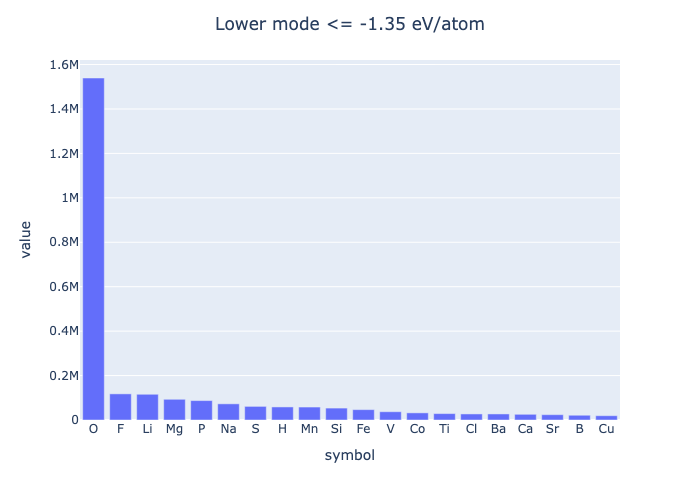

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):
    sub_formulas = df_e_form_gga_only.query(
        f"formation_energy_per_atom {comparator} {e_form_valley}"
    ).formula
    elem_counts = count_elements(sub_formulas, fill_value=0)
    fig = px.bar(elem_counts.nlargest(20))
    title = f"{label.title()} mode {comparator} {e_form_valley} eV/atom"
    fig.layout.update(title=dict(text=title, x=0.5), showlegend=False)
    fig.show()

This significant lowering of oxide formation energies compared to other anions might at least partially be an artifact of too little experimental data outside oxide systems. In other words, perhaps there should be stronger corrections applied to nitrides, selenides, etc. as well but because there's insufficient experimental data to fit a robust correction scheme there, MP doesn't.
